In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
train_data_path = '/kaggle/input/astrogeonoisy96k/noise_96k'
val_data_path = '/kaggle/input/astrogeo512x512/data_512x512_abs'

In [2]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, 4)

        self.relu = nn.ReLU()

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, image: torch.Tensor) -> torch.Tensor:
        image = self.conv1(image)
        image = self.relu(image)
        image = self.pool(image)
        image = self.conv2(image)
        image = self.relu(image)
        image = self.pool(image)
        image = self.conv3(image)
        image = self.relu(image)
        image = self.pool(image)
        image = image.view(-1, 64*16*16)
        image = self.fc1(image)
        image = self.relu(image)
        image = self.dropout(image)
        image = self.fc2(image)
        return image

In [3]:
num_epochs = 100
batch_size = 256
learning_rate = 1e-4
weight_decay = 1e-5
train_test_ratio = 0.8

In [4]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=(0, 0), translate=(0.1, 0.3), scale=None), #degrees=(0, 180)
    transforms.ToTensor()]
)
data = datasets.ImageFolder(train_data_path, transform=transform)

train_size = int(train_test_ratio * len(data))
test_size = len(data) - train_size
train, test = torch.utils.data.random_split(data, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=4)

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
model.train()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [5]:
AccTest, LossTest = [], []
y_test, predictions = [], []
def test(flag=False):
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            if flag:
                y_test.extend(labels.cpu().numpy())
                predictions.extend(predicted.cpu().numpy())
        acc = 100 * correct / total
        test_loss = test_loss / len(testloader.dataset)
        AccTest.append(acc)
        LossTest.append(test_loss)
        print(f'Epoch: {epoch+1} \tTest Loss: {test_loss:.6f} \tTest Acc: {acc:.3f}%')

In [6]:
AccTrain, LossTrain = [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    correct, total = 0, 0
    for data, target in tqdm(trainloader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        train_loss += loss.item() * data.size(0)
    if epoch + 1 == num_epochs:
        test(True)
    else:
        test()
    train_loss = train_loss / len(trainloader.dataset)
    acc = 100 * correct / total
    AccTrain.append(acc)
    LossTrain.append(train_loss)
    print(f'Epoch: {epoch+1} \tTrain Loss: {train_loss:.6f} \tTrain Acc: {acc:.3f}%')


100%|██████████| 75/75 [01:22<00:00,  1.10s/it]


Epoch: 1 	Test Loss: 0.605462 	Test Acc: 70.865%
Epoch: 1 	Train Loss: 0.916402 	Train Acc: 55.225%


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch: 2 	Test Loss: 0.458091 	Test Acc: 79.891%
Epoch: 2 	Train Loss: 0.521399 	Train Acc: 76.069%


100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Epoch: 3 	Test Loss: 0.404670 	Test Acc: 82.495%
Epoch: 3 	Train Loss: 0.429263 	Train Acc: 81.078%


100%|██████████| 75/75 [01:13<00:00,  1.03it/s]


Epoch: 4 	Test Loss: 0.369160 	Test Acc: 84.245%
Epoch: 4 	Train Loss: 0.387161 	Train Acc: 83.462%


100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Epoch: 5 	Test Loss: 0.354200 	Test Acc: 84.771%
Epoch: 5 	Train Loss: 0.362194 	Train Acc: 84.410%


100%|██████████| 75/75 [01:11<00:00,  1.04it/s]


Epoch: 6 	Test Loss: 0.329230 	Test Acc: 85.438%
Epoch: 6 	Train Loss: 0.337794 	Train Acc: 85.691%


100%|██████████| 75/75 [01:18<00:00,  1.05s/it]


Epoch: 7 	Test Loss: 0.308831 	Test Acc: 87.333%
Epoch: 7 	Train Loss: 0.321090 	Train Acc: 86.595%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 8 	Test Loss: 0.297699 	Test Acc: 87.833%
Epoch: 8 	Train Loss: 0.302166 	Train Acc: 87.409%


100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Epoch: 9 	Test Loss: 0.267941 	Test Acc: 89.167%
Epoch: 9 	Train Loss: 0.275146 	Train Acc: 88.837%


100%|██████████| 75/75 [01:17<00:00,  1.04s/it]


Epoch: 10 	Test Loss: 0.249267 	Test Acc: 89.859%
Epoch: 10 	Train Loss: 0.256817 	Train Acc: 89.605%


100%|██████████| 75/75 [01:08<00:00,  1.10it/s]


Epoch: 11 	Test Loss: 0.239111 	Test Acc: 90.391%
Epoch: 11 	Train Loss: 0.239776 	Train Acc: 90.413%


100%|██████████| 75/75 [01:08<00:00,  1.10it/s]


Epoch: 12 	Test Loss: 0.216051 	Test Acc: 91.516%
Epoch: 12 	Train Loss: 0.225219 	Train Acc: 91.069%


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


Epoch: 13 	Test Loss: 0.212567 	Test Acc: 92.042%
Epoch: 13 	Train Loss: 0.215759 	Train Acc: 91.426%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 14 	Test Loss: 0.206020 	Test Acc: 91.562%
Epoch: 14 	Train Loss: 0.203272 	Train Acc: 92.129%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 15 	Test Loss: 0.191917 	Test Acc: 92.781%
Epoch: 15 	Train Loss: 0.194727 	Train Acc: 92.374%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 16 	Test Loss: 0.187669 	Test Acc: 92.922%
Epoch: 16 	Train Loss: 0.185120 	Train Acc: 92.842%


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch: 17 	Test Loss: 0.175267 	Test Acc: 93.380%
Epoch: 17 	Train Loss: 0.177187 	Train Acc: 93.297%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 18 	Test Loss: 0.163771 	Test Acc: 93.943%
Epoch: 18 	Train Loss: 0.167883 	Train Acc: 93.659%


100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Epoch: 19 	Test Loss: 0.168905 	Test Acc: 93.594%
Epoch: 19 	Train Loss: 0.161609 	Train Acc: 93.848%


100%|██████████| 75/75 [01:15<00:00,  1.00s/it]


Epoch: 20 	Test Loss: 0.155415 	Test Acc: 94.417%
Epoch: 20 	Train Loss: 0.157207 	Train Acc: 94.014%


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch: 21 	Test Loss: 0.144591 	Test Acc: 94.724%
Epoch: 21 	Train Loss: 0.144748 	Train Acc: 94.566%


100%|██████████| 75/75 [01:15<00:00,  1.01s/it]


Epoch: 22 	Test Loss: 0.134778 	Test Acc: 95.062%
Epoch: 22 	Train Loss: 0.139453 	Train Acc: 94.832%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 23 	Test Loss: 0.133650 	Test Acc: 95.208%
Epoch: 23 	Train Loss: 0.131669 	Train Acc: 95.116%


100%|██████████| 75/75 [01:18<00:00,  1.05s/it]


Epoch: 24 	Test Loss: 0.129618 	Test Acc: 95.536%
Epoch: 24 	Train Loss: 0.128301 	Train Acc: 95.172%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 25 	Test Loss: 0.126030 	Test Acc: 95.370%
Epoch: 25 	Train Loss: 0.122372 	Train Acc: 95.525%


100%|██████████| 75/75 [01:11<00:00,  1.04it/s]


Epoch: 26 	Test Loss: 0.112993 	Test Acc: 96.104%
Epoch: 26 	Train Loss: 0.119031 	Train Acc: 95.633%


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


Epoch: 27 	Test Loss: 0.111576 	Test Acc: 95.974%
Epoch: 27 	Train Loss: 0.114291 	Train Acc: 95.789%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 28 	Test Loss: 0.107783 	Test Acc: 96.161%
Epoch: 28 	Train Loss: 0.110024 	Train Acc: 96.086%


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch: 29 	Test Loss: 0.107779 	Test Acc: 96.146%
Epoch: 29 	Train Loss: 0.109730 	Train Acc: 96.010%


100%|██████████| 75/75 [01:08<00:00,  1.10it/s]


Epoch: 30 	Test Loss: 0.114191 	Test Acc: 95.745%
Epoch: 30 	Train Loss: 0.104739 	Train Acc: 96.241%


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch: 31 	Test Loss: 0.100578 	Test Acc: 96.609%
Epoch: 31 	Train Loss: 0.101300 	Train Acc: 96.378%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 32 	Test Loss: 0.098778 	Test Acc: 96.526%
Epoch: 32 	Train Loss: 0.098833 	Train Acc: 96.529%


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


Epoch: 33 	Test Loss: 0.098452 	Test Acc: 96.745%
Epoch: 33 	Train Loss: 0.096677 	Train Acc: 96.568%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 34 	Test Loss: 0.092172 	Test Acc: 96.896%
Epoch: 34 	Train Loss: 0.096398 	Train Acc: 96.569%


100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Epoch: 35 	Test Loss: 0.092742 	Test Acc: 96.844%
Epoch: 35 	Train Loss: 0.090192 	Train Acc: 96.837%


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


Epoch: 36 	Test Loss: 0.088233 	Test Acc: 96.932%
Epoch: 36 	Train Loss: 0.089218 	Train Acc: 96.898%


100%|██████████| 75/75 [01:26<00:00,  1.16s/it]


Epoch: 37 	Test Loss: 0.087531 	Test Acc: 96.958%
Epoch: 37 	Train Loss: 0.087201 	Train Acc: 96.964%


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch: 38 	Test Loss: 0.083455 	Test Acc: 97.167%
Epoch: 38 	Train Loss: 0.086142 	Train Acc: 96.958%


100%|██████████| 75/75 [01:24<00:00,  1.13s/it]


Epoch: 39 	Test Loss: 0.081822 	Test Acc: 97.260%
Epoch: 39 	Train Loss: 0.084123 	Train Acc: 97.047%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 40 	Test Loss: 0.082341 	Test Acc: 97.177%
Epoch: 40 	Train Loss: 0.082820 	Train Acc: 97.137%


100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Epoch: 41 	Test Loss: 0.080302 	Test Acc: 97.203%
Epoch: 41 	Train Loss: 0.080342 	Train Acc: 97.230%


100%|██████████| 75/75 [01:17<00:00,  1.03s/it]


Epoch: 42 	Test Loss: 0.081253 	Test Acc: 97.115%
Epoch: 42 	Train Loss: 0.078663 	Train Acc: 97.280%


100%|██████████| 75/75 [01:16<00:00,  1.02s/it]


Epoch: 43 	Test Loss: 0.078713 	Test Acc: 97.297%
Epoch: 43 	Train Loss: 0.077809 	Train Acc: 97.298%


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch: 44 	Test Loss: 0.072554 	Test Acc: 97.531%
Epoch: 44 	Train Loss: 0.075457 	Train Acc: 97.393%


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch: 45 	Test Loss: 0.071717 	Test Acc: 97.557%
Epoch: 45 	Train Loss: 0.076008 	Train Acc: 97.363%


100%|██████████| 75/75 [01:23<00:00,  1.11s/it]


Epoch: 46 	Test Loss: 0.070025 	Test Acc: 97.656%
Epoch: 46 	Train Loss: 0.074372 	Train Acc: 97.414%


100%|██████████| 75/75 [01:15<00:00,  1.00s/it]


Epoch: 47 	Test Loss: 0.075642 	Test Acc: 97.552%
Epoch: 47 	Train Loss: 0.073155 	Train Acc: 97.490%


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch: 48 	Test Loss: 0.071804 	Test Acc: 97.609%
Epoch: 48 	Train Loss: 0.072586 	Train Acc: 97.565%


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


Epoch: 49 	Test Loss: 0.071373 	Test Acc: 97.599%
Epoch: 49 	Train Loss: 0.070177 	Train Acc: 97.578%


100%|██████████| 75/75 [01:17<00:00,  1.04s/it]


Epoch: 50 	Test Loss: 0.069147 	Test Acc: 97.641%
Epoch: 50 	Train Loss: 0.068911 	Train Acc: 97.663%


100%|██████████| 75/75 [01:13<00:00,  1.01it/s]


Epoch: 51 	Test Loss: 0.069052 	Test Acc: 97.568%
Epoch: 51 	Train Loss: 0.067552 	Train Acc: 97.686%


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch: 52 	Test Loss: 0.064690 	Test Acc: 97.839%
Epoch: 52 	Train Loss: 0.068514 	Train Acc: 97.660%


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch: 53 	Test Loss: 0.062367 	Test Acc: 97.844%
Epoch: 53 	Train Loss: 0.067389 	Train Acc: 97.673%


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


Epoch: 54 	Test Loss: 0.076370 	Test Acc: 97.354%
Epoch: 54 	Train Loss: 0.065071 	Train Acc: 97.780%


100%|██████████| 75/75 [01:15<00:00,  1.01s/it]


Epoch: 55 	Test Loss: 0.064328 	Test Acc: 97.854%
Epoch: 55 	Train Loss: 0.063890 	Train Acc: 97.858%


100%|██████████| 75/75 [01:13<00:00,  1.03it/s]


Epoch: 56 	Test Loss: 0.063040 	Test Acc: 97.802%
Epoch: 56 	Train Loss: 0.062528 	Train Acc: 97.918%


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


Epoch: 57 	Test Loss: 0.065120 	Test Acc: 97.766%
Epoch: 57 	Train Loss: 0.061006 	Train Acc: 97.935%


100%|██████████| 75/75 [01:13<00:00,  1.01it/s]


Epoch: 58 	Test Loss: 0.061326 	Test Acc: 98.078%
Epoch: 58 	Train Loss: 0.062137 	Train Acc: 97.885%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 59 	Test Loss: 0.064200 	Test Acc: 97.865%
Epoch: 59 	Train Loss: 0.061042 	Train Acc: 97.964%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 60 	Test Loss: 0.059615 	Test Acc: 98.016%
Epoch: 60 	Train Loss: 0.059023 	Train Acc: 98.044%


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


Epoch: 61 	Test Loss: 0.060029 	Test Acc: 98.057%
Epoch: 61 	Train Loss: 0.061013 	Train Acc: 97.948%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 62 	Test Loss: 0.059571 	Test Acc: 98.094%
Epoch: 62 	Train Loss: 0.057128 	Train Acc: 98.126%


100%|██████████| 75/75 [01:11<00:00,  1.04it/s]


Epoch: 63 	Test Loss: 0.060959 	Test Acc: 97.953%
Epoch: 63 	Train Loss: 0.057704 	Train Acc: 98.031%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 64 	Test Loss: 0.059135 	Test Acc: 98.130%
Epoch: 64 	Train Loss: 0.057137 	Train Acc: 98.074%


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch: 65 	Test Loss: 0.061615 	Test Acc: 97.922%
Epoch: 65 	Train Loss: 0.055364 	Train Acc: 98.139%


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch: 66 	Test Loss: 0.055317 	Test Acc: 98.240%
Epoch: 66 	Train Loss: 0.054014 	Train Acc: 98.186%


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch: 67 	Test Loss: 0.051560 	Test Acc: 98.224%
Epoch: 67 	Train Loss: 0.055180 	Train Acc: 98.151%


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


Epoch: 68 	Test Loss: 0.048279 	Test Acc: 98.505%
Epoch: 68 	Train Loss: 0.054581 	Train Acc: 98.208%


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch: 69 	Test Loss: 0.049080 	Test Acc: 98.469%
Epoch: 69 	Train Loss: 0.052399 	Train Acc: 98.319%


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch: 70 	Test Loss: 0.064716 	Test Acc: 97.776%
Epoch: 70 	Train Loss: 0.051364 	Train Acc: 98.371%


100%|██████████| 75/75 [01:11<00:00,  1.06it/s]


Epoch: 71 	Test Loss: 0.050265 	Test Acc: 98.422%
Epoch: 71 	Train Loss: 0.050997 	Train Acc: 98.340%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 72 	Test Loss: 0.055084 	Test Acc: 98.104%
Epoch: 72 	Train Loss: 0.049948 	Train Acc: 98.345%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 73 	Test Loss: 0.050437 	Test Acc: 98.411%
Epoch: 73 	Train Loss: 0.049805 	Train Acc: 98.342%


100%|██████████| 75/75 [01:09<00:00,  1.08it/s]


Epoch: 74 	Test Loss: 0.051270 	Test Acc: 98.380%
Epoch: 74 	Train Loss: 0.049858 	Train Acc: 98.319%


100%|██████████| 75/75 [01:11<00:00,  1.05it/s]


Epoch: 75 	Test Loss: 0.051186 	Test Acc: 98.354%
Epoch: 75 	Train Loss: 0.050229 	Train Acc: 98.371%


100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Epoch: 76 	Test Loss: 0.052646 	Test Acc: 98.292%
Epoch: 76 	Train Loss: 0.048265 	Train Acc: 98.448%


100%|██████████| 75/75 [01:11<00:00,  1.04it/s]


Epoch: 77 	Test Loss: 0.047435 	Test Acc: 98.557%
Epoch: 77 	Train Loss: 0.047413 	Train Acc: 98.404%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 78 	Test Loss: 0.045617 	Test Acc: 98.495%
Epoch: 78 	Train Loss: 0.046445 	Train Acc: 98.510%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 79 	Test Loss: 0.045631 	Test Acc: 98.547%
Epoch: 79 	Train Loss: 0.045152 	Train Acc: 98.513%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 80 	Test Loss: 0.046203 	Test Acc: 98.505%
Epoch: 80 	Train Loss: 0.046505 	Train Acc: 98.458%


100%|██████████| 75/75 [01:17<00:00,  1.04s/it]


Epoch: 81 	Test Loss: 0.044364 	Test Acc: 98.526%
Epoch: 81 	Train Loss: 0.044189 	Train Acc: 98.547%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 82 	Test Loss: 0.041656 	Test Acc: 98.729%
Epoch: 82 	Train Loss: 0.045422 	Train Acc: 98.470%


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


Epoch: 83 	Test Loss: 0.042644 	Test Acc: 98.719%
Epoch: 83 	Train Loss: 0.043619 	Train Acc: 98.595%


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


Epoch: 84 	Test Loss: 0.041766 	Test Acc: 98.625%
Epoch: 84 	Train Loss: 0.043082 	Train Acc: 98.594%


100%|██████████| 75/75 [01:08<00:00,  1.10it/s]


Epoch: 85 	Test Loss: 0.041556 	Test Acc: 98.646%
Epoch: 85 	Train Loss: 0.042010 	Train Acc: 98.672%


100%|██████████| 75/75 [01:24<00:00,  1.13s/it]


Epoch: 86 	Test Loss: 0.037882 	Test Acc: 98.776%
Epoch: 86 	Train Loss: 0.042380 	Train Acc: 98.643%


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


Epoch: 87 	Test Loss: 0.038212 	Test Acc: 98.828%
Epoch: 87 	Train Loss: 0.042816 	Train Acc: 98.595%


100%|██████████| 75/75 [01:17<00:00,  1.03s/it]


Epoch: 88 	Test Loss: 0.039160 	Test Acc: 98.724%
Epoch: 88 	Train Loss: 0.039659 	Train Acc: 98.720%


100%|██████████| 75/75 [01:08<00:00,  1.09it/s]


Epoch: 89 	Test Loss: 0.040088 	Test Acc: 98.646%
Epoch: 89 	Train Loss: 0.041173 	Train Acc: 98.698%


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch: 90 	Test Loss: 0.037470 	Test Acc: 98.833%
Epoch: 90 	Train Loss: 0.040516 	Train Acc: 98.702%


100%|██████████| 75/75 [01:10<00:00,  1.07it/s]


Epoch: 91 	Test Loss: 0.039422 	Test Acc: 98.745%
Epoch: 91 	Train Loss: 0.040298 	Train Acc: 98.685%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 92 	Test Loss: 0.036670 	Test Acc: 98.802%
Epoch: 92 	Train Loss: 0.038554 	Train Acc: 98.740%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 93 	Test Loss: 0.036330 	Test Acc: 98.828%
Epoch: 93 	Train Loss: 0.039239 	Train Acc: 98.750%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 94 	Test Loss: 0.039207 	Test Acc: 98.724%
Epoch: 94 	Train Loss: 0.039103 	Train Acc: 98.745%


100%|██████████| 75/75 [01:11<00:00,  1.06it/s]


Epoch: 95 	Test Loss: 0.036895 	Test Acc: 98.755%
Epoch: 95 	Train Loss: 0.037361 	Train Acc: 98.806%


100%|██████████| 75/75 [01:13<00:00,  1.01it/s]


Epoch: 96 	Test Loss: 0.042915 	Test Acc: 98.604%
Epoch: 96 	Train Loss: 0.037557 	Train Acc: 98.781%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 97 	Test Loss: 0.034599 	Test Acc: 98.880%
Epoch: 97 	Train Loss: 0.037635 	Train Acc: 98.822%


100%|██████████| 75/75 [01:10<00:00,  1.06it/s]


Epoch: 98 	Test Loss: 0.040695 	Test Acc: 98.729%
Epoch: 98 	Train Loss: 0.038143 	Train Acc: 98.751%


100%|██████████| 75/75 [01:15<00:00,  1.01s/it]


Epoch: 99 	Test Loss: 0.035190 	Test Acc: 98.875%
Epoch: 99 	Train Loss: 0.036543 	Train Acc: 98.870%


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]

Epoch: 100 	Test Loss: 0.039204 	Test Acc: 98.802%
Epoch: 100 	Train Loss: 0.035822 	Train Acc: 98.846%


In [7]:
torch.save(model.state_dict(), 'noise.pth')

Precision: 98.853 %
Recall: 98.789 %
F1 Score: 98.821 %
F1 Macro Score: 98.801 %
F1 Weighted Score: 98.801 %


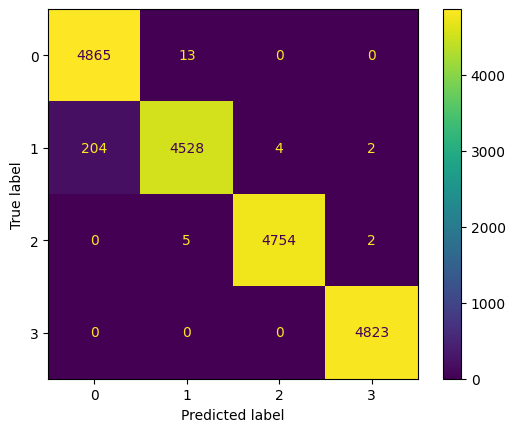

In [8]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()
plt.savefig(f'ConfMatrix_noise.png', dpi=500)

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
    
f1 = 2 * precision * recall / (precision + recall)
f1_macro = f1_score(y_test, predictions, average='macro')
f1_weighted = f1_score(y_test, predictions, average='weighted')
print(f'Precision: {100 * precision:.3f} %')
print(f'Recall: {100 * recall:.3f} %')
print(f'F1 Score: {100 * f1:.3f} %')
print(f'F1 Macro Score: {100 * f1_macro:.3f} %')
print(f'F1 Weighted Score: {100 * f1_weighted:.3f} %')

In [9]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class AstrogeoDataset(Dataset):
    def __init__(self, dir: str, transform=None) -> None:
        self.transform = transform
        self.images = os.listdir(dir)
        self.dir = dir

    def __getitem__(self, index: int) -> tuple:
        image = read_image(
            f'{self.dir}/{self.images[index]}',
            mode=ImageReadMode.RGB
        )
        file_name = self.images[index]
        if self.transform is not None:
            image = self.transform(image)
        return (file_name, image)

    def __len__(self) -> int:
        return len(self.images)

In [10]:
import json
import pandas as pd

transform = transforms.Compose([
    transforms.ToPILImage(), transforms.Resize((128, 128)),
    transforms.Grayscale(), transforms.ToTensor()]
)
val = AstrogeoDataset(val_data_path, transform=transform)
valloader = torch.utils.data.DataLoader(
    val, batch_size=batch_size, shuffle=True, num_workers=4
)

model.eval()
val_preds = {}
with torch.no_grad():
    for file_names, images in tqdm(valloader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.update(dict(zip(file_names, predicted.cpu().tolist())))
        
with open('predicts.json', 'w') as f:
    json.dump(val_preds, f)

s1 = pd.Series(val_preds.keys())
s2 = pd.Series(val_preds.values())
df = pd.concat([s1, s2], axis=1)
df = df.rename(columns={0: 'file_name', 1: 'predicted_class'})
df.to_csv('classification.csv')

100%|██████████| 350/350 [05:13<00:00,  1.12it/s]


{0: 87116, 1: 2229, 2: 236, 3: 4}


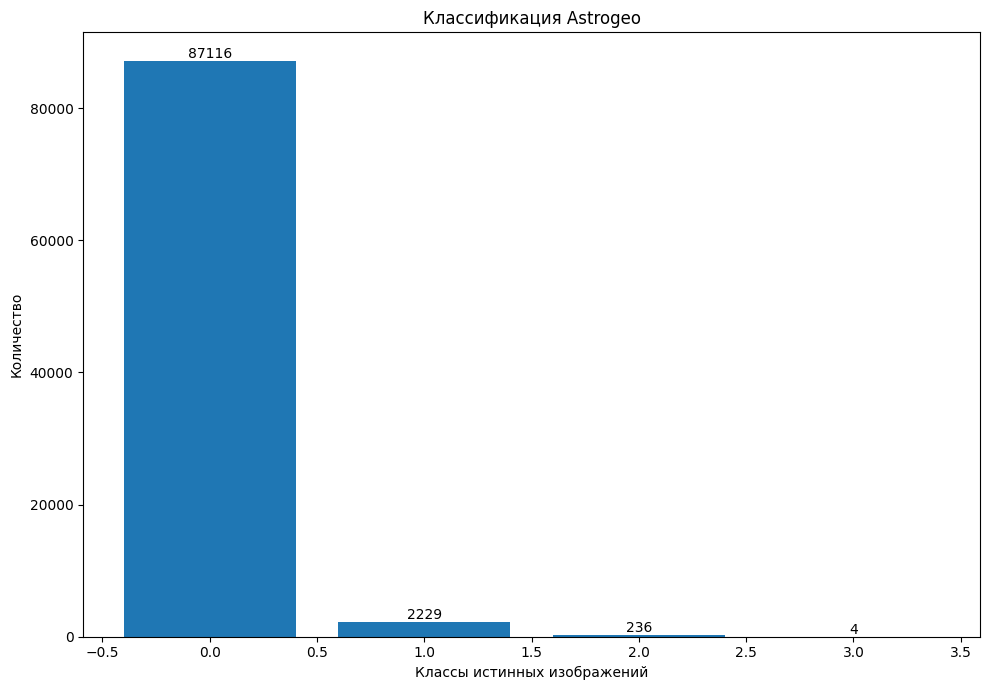

In [11]:
from collections import Counter

labels = [
    'Одиночный источник', 'Двойной источник',
    'Источник с джетом', 'Источник с двойным джетом'
]
res = dict(Counter(val_preds.values()))
res = {k: v for k, v in sorted(res.items())}
print(res)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
bar = ax.bar(res.keys(), res.values())
ax.bar_label(bar, labels=res.values())
ax.set_xlabel('Классы истинных изображений')
ax.set_ylabel('Количество')
ax.set_title('Классификация Astrogeo')
fig.tight_layout()
plt.savefig('histogram.png', dpi=500)

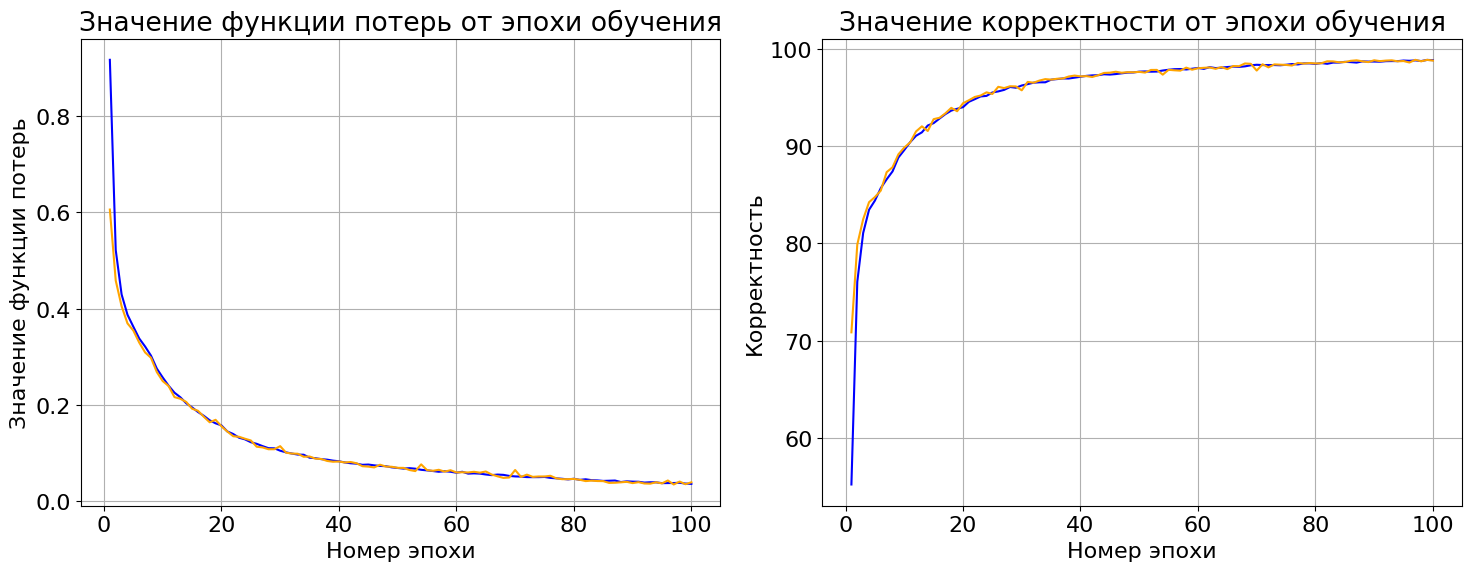

In [12]:
import numpy as np

plt.rcParams.update({'font.size': 16})
epochs = np.arange(1, num_epochs + 1)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(epochs, LossTrain, label='train', color='blue')
axes[0].plot(epochs, LossTest, label='test', color='orange')
axes[0].set_title('Значение функции потерь от эпохи обучения')
axes[0].set_xlabel('Номер эпохи')
axes[0].set_ylabel('Значение функции потерь')
axes[0].grid()

axes[1].plot(epochs, AccTrain, label='train', color='blue')
axes[1].plot(epochs, AccTest, label='test', color='orange')
axes[1].set_title('Значение корректности от эпохи обучения')
axes[1].set_ylabel('Корректность')
axes[1].set_xlabel('Номер эпохи')
axes[1].grid()
plt.tight_layout()
plt.savefig('train.png', dpi=500)